# ros_gmapping_movebase

## Introduction

This jupyter notebook serves as a user interface for a rospackage that implements three behaviors for controlling a simulated mobile robot, which can provide us the map of the environment using gmapping and movebase rospackages.

Robot behaviors are these three options:

1. Choosing a goal point and using the movebase node for path planning
2. Controlling the robot through direction commands with and without obstacle avoidance


<div align="left">
<img src="preview.png" width="75%" height="75%">
</div>

## Usage

### Installation

Here is the instruction for installing the package:

```bashscript
$ mkdir -p catkin_ws/src
$ cd catkin_ws/src
$ git clone https://github.com/aliy98/ros_gmapping_movebase
$ cd ..
$ source /opt/ros/<distro>/setup.bash
$ catkin_make
```

### Running

You can initialize the simulation environment in gazebo and run rviz in the same time using the commands below

```bashscript
$ source devel/setup.bash
$ roslaunch final_assignment simulation_gmapping.launch
```

In order to run the *movebase node*, open a new terminal in the same directory and run the following commands:

```bashscript
$ source devel/setup.bash
$ roslaunch final_assignment move_base.launch
```

For initializing the rospackage which is connected to this jupyter notebook, in a new terminal run the following commands:

```bashscript
$ source devel/setup.bash
$ roslaunch final_assignment master.launch
```

Now you can keep running the following cells for using this interface with the rospackage

## Importing Required Modules

In [1]:
import rospy
from std_srvs.srv import *
from std_msgs.msg import String
from nav_msgs.msg import Odometry
from tf.transformations import quaternion_matrix
import jupyros as jr
import tf
import os
import ipywidgets as widgets
from ipywidgets import Button, Output, Layout, ButtonStyle, GridBox, VBox, HBox
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation

## Defining Required Classes
There are 5 classes that are used in this jupyter notebook to make it more modular and easy to use. In the next cells we will take instances from these classes in order to use the interface for this rospackage.

In [2]:
class SwitchMode:
    def __init__(self):
        self.w = widgets.RadioButtons(
            options=['1. goal point', '2. control with direction', 
                     '3. control with direction and obstacle avoidance'],
            layout={'width': 'max-content'}, 
            disabled=False
        )
        self.b = Button(description='Apply Mode',layout=Layout(width='auto', grid_area='b'),style=ButtonStyle(button_color='lightblue'))
        self.o = Output()
        
    def on_button_clicked(self, b):
        with self.o:
            if self.w.value == '1. goal point':
                rospy.set_param('robot_state', '1')
            elif self.w.value == '2. control with direction':
                rospy.set_param('robot_state', '2')
            elif self.w.value == '3. control with direction and obstacle avoidance':
                rospy.set_param('robot_state', '3')
                

In [3]:
class SendTarget:
    def __init__(self):
        self.goal = widgets.Text()
        self.b = Button(description='Apply Goal Point',layout=Layout(width='auto', grid_area='b'),style=ButtonStyle(button_color='lightblue'))
        self.o = Output()
        self.pub = rospy.Publisher('/movebase_client_goal', String, queue_size=10)
        
    def on_button_clicked(self, b):
        with self.o:
            self.pub.publish(self.goal.value)
            rospy.set_param('input_target', '1')
            
    def main(self):
        self.b.on_click(self.on_button_clicked)
        display(self.goal)

In [4]:
class TargetsAnalysis:
    def __init__(self):
        self.reached_target = 0
        self.not_reached_target = 0
        self.fig = plt.figure(figsize=(8,2))
        self.b = Button(description='Reload Plot',layout=Layout(width='auto', grid_area='b'),style=ButtonStyle(button_color='lightblue'))
        self.o = Output()
        
    def get_target_param(self):
        if (rospy.has_param('/reached_targets')):
            self.reached_target = rospy.get_param('/reached_targets')
        if (rospy.has_param('/not_reached_targets')):
            self.not_reached_target = rospy.get_param('/not_reached_targets')
            
    def plot_init(self):
        self.axes_2 = self.fig.add_axes([0.2, 0.3, 0.7, 0.4])
        self.axes_2.set_title('Number of not_reached and reached Targets')
        self.get_target_param()
        self.axes_2.barh(('reached\ntargets', 'not_reached\ntargets'),(self.reached_target, self.not_reached_target),color=[ 'green','red'])
    
    def on_button_clicked(self, b):
        with self.o:
            self.axes_2.cla()
            self.plot_init()

In [5]:
class Visualiser:
    def __init__(self):
        self.fig = plt.figure(figsize=(5,3))
        self.ax = self.fig.add_axes([0.2,0.2,0.7,0.7]) # here is where the sectioning of the axis of the figure is done 
        self.ax.set_title('Robot Footprint')
        self.ax.set_xlabel('X Coordinate')
        self.ax.set_ylabel('Y Coordinate')
        self.ln, = plt.plot([], [], 'ro')
        self.x_data, self.y_data = [] , []
 
    def plot_init(self):
        self.ax.set_xlim(-10, 10)
        self.ax.set_ylim(-10, 10)
        return self.ln

    def odom_callback(self, msg):
        self.y_data.append(msg.pose.pose.position.y)
        self.x_data.append(msg.pose.pose.position.x)

    def update_plot(self, frame):
        self.ln.set_data(self.x_data, self.y_data)
        return self.ln

In [6]:
class TeleopButtons:
    def __init__(self):
        self.b1 = Button(description='u',layout=Layout(width='auto', grid_area='b1'),style=ButtonStyle(button_color='lightblue'))
        self.o1 = Output()
        self.b2 = Button(description='j',layout=Layout(width='auto', grid_area='b2'),style=ButtonStyle(button_color='salmon'))
        self.o2 = Output()
        self.b3 = Button(description='m',layout=Layout(width='auto', grid_area='b3'),style=ButtonStyle(button_color='lightblue'))
        self.o3 = Output()
        self.b4 = Button(description='i',layout=Layout(width='auto', grid_area='b4'),style=ButtonStyle(button_color='salmon'))
        self.o4 = Output()
        self.b5 = Button(description='k',layout=Layout(width='auto', grid_area='b5'),style=ButtonStyle(button_color='lightblue'))
        self.o5 = Output()
        self.b6 = Button(description=',',layout=Layout(width='auto', grid_area='b5'),style=ButtonStyle(button_color='salmon'))
        self.o6 = Output()
        self.b7 = Button(description='o',layout=Layout(width='auto', grid_area='b5'),style=ButtonStyle(button_color='lightblue'))
        self.o7 = Output()
        self.b8 = Button(description='l',layout=Layout(width='auto', grid_area='b5'),style=ButtonStyle(button_color='salmon'))
        self.o8 = Output()
        self.b9 = Button(description='.',layout=Layout(width='auto', grid_area='b5'),style=ButtonStyle(button_color='lightblue'))
        self.o9 = Output()
        self.pub = rospy.Publisher('/teleop_input_key', String, queue_size=10)

    def on_button_clicked1(self, b):
        with self.o1:
            self.pub.publish('u')
    def on_button_clicked2(self, b):
        with self.o2:
            self.pub.publish('j')
    def on_button_clicked3(self, b):
        with self.o3:
            self.pub.publish('m')
    def on_button_clicked4(self, b):
        with self.o4:
            self.pub.publish('i')
    def on_button_clicked5(self, b):
        with self.o5:
            self.pub.publish('k')
    def on_button_clicked6(self, b):
        with self.o6:
            self.pub.publish(',')
    def on_button_clicked7(self, b):
        with self.o7:
            self.pub.publish('o')
    def on_button_clicked8(self, b):
        with self.o8:
            self.pub.publish('l')
    def on_button_clicked9(self, b):
        with self.o9:
            self.pub.publish('.')

    def main(self):
        self.b1.on_click(self.on_button_clicked1)
        self.b2.on_click(self.on_button_clicked2)
        self.b3.on_click(self.on_button_clicked3)
        self.b4.on_click(self.on_button_clicked4)
        self.b5.on_click(self.on_button_clicked5)
        self.b6.on_click(self.on_button_clicked6)
        self.b7.on_click(self.on_button_clicked7)
        self.b8.on_click(self.on_button_clicked8)
        self.b9.on_click(self.on_button_clicked9)           

## Switching to the different modalities

There are two cells for this section. First you choose the robot behaviour with the radio button and then run the second cell to apply it to the robot, then you can move to the correspinding cell for that behaviour. In this section we use a rosparam which is **/robot_state** to change robot behaviour.

In [8]:
rospy.init_node('jupyter_node')  
sm = SwitchMode()
sm.b.on_click(sm.on_button_clicked)
display(sm.w)
sm.b

RadioButtons(layout=Layout(width='max-content'), options=('1. goal point', '2. control with direction', '3. co…

Button(description='Apply Mode', layout=Layout(grid_area='b', width='auto'), style=ButtonStyle(button_color='l…

## 1. Goal point (for the first mode)

In this part you can publish a goal point to **/movebase_client_goal** topic, which is subscribed by *movebase_client node*. This goal point will be sent to *movebase node* with **/move_base/action_topics** for path-planning and also using this topic we can detect if the goal point has been reached or not. The numbers of reached and not reached targets are saved in two rosparams so that we can visualize them in a bar graph. 

In [9]:
print("enter goal position in format x,y:")
st = SendTarget()
st.main()
st.b

enter goal position in format x,y:


Text(value='')

Button(description='Apply Goal Point', layout=Layout(grid_area='b', width='auto'), style=ButtonStyle(button_co…

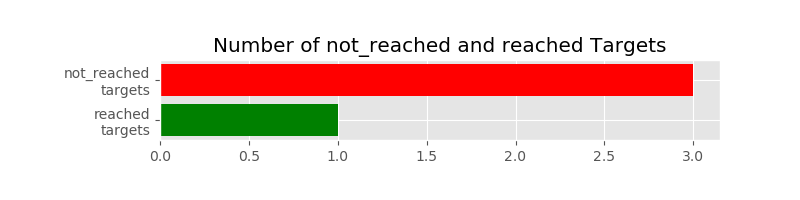

Button(description='Reload Plot', layout=Layout(grid_area='b', width='auto'), style=ButtonStyle(button_color='…

In [21]:
%matplotlib widget
ta = TargetsAnalysis()
ta.plot_init()
ta.b.on_click(ta.on_button_clicked)
plt.show()
ta.b

## 2. Move with directions (for the second and third modes)
it can implement two behaviours on robot:
1. moving without obstacle avoidance: user can move the robot using keys it publishes the desired movements to cmd_vel topic

2. moveing with obstacle avoidance: subscribes scan topic and uses it to detect obstacles. user can move the robot using keys and it also avoids the robot from colliding the obstacles

In [18]:
print("input direction:")
tb = TeleopButtons()
tb.main()
HBox([VBox([tb.b1, tb.b2, tb.b3]),VBox([tb.b4, tb.b5, tb.b6]),VBox([tb.b7, tb.b8, tb.b9])])

input direction:


## Visualiser
In this jupyter notebook there is also the posibility of visualizing the position of the robot in a 2D plot. Robot position can be read from the topic **/odom**. 

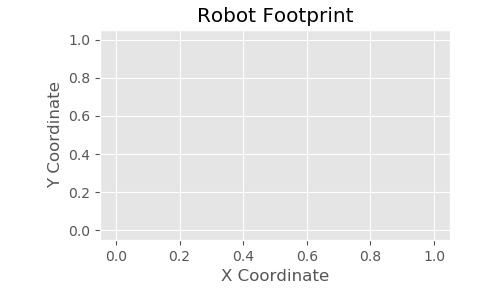

In [19]:
%matplotlib widget
plt.style.use('ggplot')
vis = Visualiser()
sub = rospy.Subscriber('/odom', Odometry, vis.odom_callback)
ani = FuncAnimation(vis.fig, vis.update_plot, init_func=vis.plot_init,blit=True)
plt.show(block=True)

## Laser Scanner Data
With the help of jupyros module, we can visulize the laser scanner data in jupyter notebook. After taking an instance of **ros3d.Viewer** we make a connection between jupyter and rosserver and then save the tf_client, laserview, mapview, path and robots urdf from their topics into their corresponding variables we can initilize the process.

In [22]:
v = jr.ros3d.Viewer()
rc = jr.ros3d.ROSConnection(url="ws://localhost:9090")
tf_client = jr.ros3d.TFClient(ros=rc, fixed_frame='map')
laser_view = jr.ros3d.LaserScan(topic="/scan", ros=rc, tf_client=tf_client)
map_view = jr.ros3d.OccupancyGrid(topic="/map", ros=rc, tf_client=tf_client)
path = jr.ros3d.Path(topic="/move_base/NavfnROS/plan", ros=rc,
tf_client=tf_client)
urdf = jr.ros3d.URDFModel(ros=rc, tf_client=tf_client,
path=os.environ.get('JUPYROS_ASSETS_URL', 'http://localhost:3000'))
g = jr.ros3d.GridModel()
v.objects = [g, laser_view, map_view, path, urdf]
v

Viewer(objects=[GridModel(), LaserScan(ros=ROSConnection(url='ws://localhost:9090'), tf_client=TFClient(fixed_…